In [2]:
# -*- coding: utf-8 -*-
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from fiona.errors import DriverError
from fiona.drvsupport import supported_drivers
from configparser import ConfigParser
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM

# 為cartpy0.17bug暫時添加
import six
from PIL import Image



file_shp 發現檔案:
COUNTY_MOI_1081121

file_csv 發現檔案:
氣象測站

file_xml 發現檔案:
沒有發現任何檔案

讀取檔案: COUNTY_MOI_1081121.shp
原座標系統： +init=epsg:4326 +type=crs
轉換為： epsg:4326
  COUNTYID COUNTYCODE COUNTYNAME          COUNTYENG  \
0        Z      09007        連江縣  Lienchiang County   
1        G      10002        宜蘭縣       Yilan County   
2        N      10007        彰化縣    Changhua County   
3        M      10008        南投縣      Nantou County   
4        P      10009        雲林縣      Yunlin County   

                                            geometry  
0  MULTIPOLYGON (((119.96445 25.94552, 119.96427 ...  
1  MULTIPOLYGON (((121.95971 24.84494, 121.96064 ...  
2  POLYGON ((120.45655 24.20719, 120.48589 24.197...  
3  POLYGON ((121.27086 24.23661, 121.27108 24.236...  
4  MULTIPOLYGON (((120.08108 23.52412, 120.08161 ...  

讀取檔案: 氣象測站.csv
原座標系統： +init=epsg:4326 +type=crs
轉換為： epsg:4326
  Station_num Station_name       Lon      Lat COUNTYNAME field_6  \
0      466850       五分山雷達站  121.7812  25.0712   

C:\Users\cvb14\anaconda3\envs\PyGIS_ExportPic\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\cvb14\anaconda3\envs\PyGIS_ExportPic\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


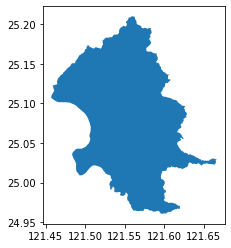

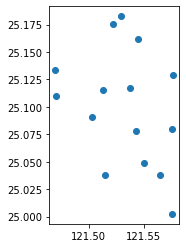

In [3]:
read_files = []
file_set = []
df_set = []
counter = 0
ext = ""
# 建立傳給gp.read_file的額外參數 (csv用)
options = {}
cfg = ConfigParser()
cfg.read('config.ini', encoding='utf-8-sig')
# 由ini讀入各格式檔名
for section in cfg.sections():
    read_files.append(cfg[section]['name'])
    print("\n{} 發現檔案:".format(section))
    for temp in read_files[cfg.sections().index(section)].split(','):
        print(temp) if temp!="" else print("沒有發現任何檔案")

try:
    # 讀檔
    for files in read_files:
        if files != "":
            # 重置額外參數
            options = {}
            # 分割當前種類檔名
            fs = files.split(',')
            for f in fs:
                file_set.append(f)
                # shp檔
                if counter == 0:
                    ext = "shp"
                # csv檔
                elif counter == 1:
                    ext = "csv"
                    # 啟用指定的fiona驅動
                    # 參見: https://gdal.org/drivers/vector/index.html
                    supported_drivers['CSV'] = 'rw'
                    # 指定經緯度參數的欄位名稱
                    # 參見: https://gdal.org/drivers/vector/csv.html#reading-csv-containing-spatial-information
                    options['X_POSSIBLE_NAMES']='Lon'
                    options['Y_POSSIBLE_NAMES']='Lat'
                # xml檔
                else:
                    ext = "xml"
                    supported_drivers['libkml'] = 'rw'
                    supported_drivers['LIBKML'] = 'rw'

                print("\n讀取檔案: {}.{}".format(f, ext) )
                df = gp.read_file("./input/{}.{}".format(f, ext), encoding='utf-8', **options)
                df.crs = {'init' :'epsg:4326'} # 避免input沒給 這邊給預設值(WGS84)
                print("原座標系統： {}".format(df.crs))
                # 座標轉換
                df = df.to_crs(epsg=4326)
                print("轉換為： {}".format(df.crs))
                print(df.head())
                # 只取geometry
                search = u"臺北市"
                df = df[df["COUNTYNAME"]==search]
                df = df[['COUNTYNAME','geometry']]
                df.reset_index(drop=True)
                df_set.append(df)
                df.plot()
            counter += 1
except DriverError:
    print("無法讀取檔案: {}!".format(f))

In [4]:
# 迭代各dataframe 回傳經緯度min/max (minx/miny/maxx/maxy)
bound = [9999, 0, 9999 , 0] # 預設值
for df in df_set:
    bounds = df.geometry.bounds
    margin = 0.03
    # 檢查各值 符合條件(更大的bound框)則更新
    bound = [min(bounds.minx)-margin if min(bounds.minx)<bound[0] else bound[0], # 最小經度
             max(bounds.maxx)+margin if max(bounds.maxx)>bound[1] else bound[1], # 最大經度
             min(bounds.miny)-margin if min(bounds.miny)<bound[2] else bound[2], # 最小緯度
             max(bounds.maxy)+margin if max(bounds.maxy)>bound[3] else bound[3]] # 最大緯度
print(bound)

[121.42714093900005, 121.69593430800003, 24.930502697000037, 25.240175205000043]


In [5]:
def new_get_image(self, tile):
    if six.PY3:
        from urllib.request import urlopen, Request
    else:
        from urllib2 import urlopen
    url = self._image_url(tile)  # added by H.C. Winsemius
    req = Request(url) # added by H.C. Winsemius
    req.add_header('User-agent', 'your bot 0.1')
    # fh = urlopen(url)  # removed by H.C. Winsemius
    fh = urlopen(req)
    im_data = six.BytesIO(fh.read())
    fh.close()
    img = Image.open(im_data)

    img = img.convert(self.desired_tile_form)

    return img, self.tileextent(tile), 'lower'

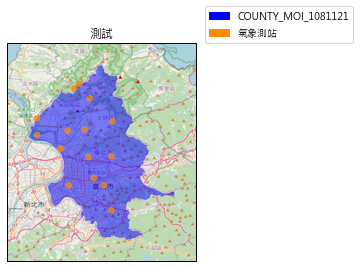

In [7]:
# 解決matplotlib本身不支援中文字體 會顯示成方塊的問題
# 參見： https://stackoverflow.com/questions/10960463/non-ascii-characters-in-matplotlib
plt.rcParams['axes.unicode_minus'] = False # 解決負號 '-' 顯示為方塊的問題
plt.rc('font', **{'sans-serif' : 'Microsoft JhengHei', # 指定中文字體 (微軟正黑體)
                  'family' : 'sans-serif'}) # 指定默認字型

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_title("測試")
ax.set_extent(bound, ccrs.PlateCarree())
OSM.get_image = new_get_image
imagery = OSM()
# interpolation: matplotlib抗鋸齒
# 待0.18.1發佈更新 可修正下述bug
# cartopy0.18版interpolation有bug
# 參見: https://github.com/SciTools/cartopy/issues/1563
# cartopy0.17版add_image有bug
# 參見: https://github.com/SciTools/cartopy/issues/1341
zoom = 11
inter = 'spline36'
# regrid_shape: basemap長寬之短邊尺寸
regrid = 2500
dpi = 3000
ax.add_image(imagery, zoom, interpolation=inter, regrid_shape=regrid)

# 在指定的色彩表中取等間隔序列隨機生成顏色
# 參見: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
# 或使用十六進位色碼, 列表： https://www.ebaomonthly.com/window/photo/lesson/colorList.htm
cmap = plt.get_cmap('rainbow')
colors = cmap(np.linspace(0,1, len(file_set)))
patchs = []
for label, color, df in zip(file_set, colors, df_set):
    if sum(df.geom_type == 'Point') != 0: # polnt無法add_geometries轉多邊形 改用scatter散佈圖方式
        c='#FF8C00'
        ax.scatter([point.x for point in df.geometry],
                   [point.y for point in df.geometry],
                   s=[30 for i in range(len(df.geometry))], # s = size:控制每個點大小的list
                   #c=np.array([color]),  # c = color:色彩表的顏色需用np.array轉2Darray
                   c=c,
                   alpha=0.7,
                   transform=ccrs.PlateCarree(),
                   zorder=2) # Zorder:大的在上面 預設為先畫的在上面
    else:
        c='blue'
        ax.add_geometries(df.geometry,
                          ccrs.PlateCarree(),
                          edgecolor='white',
                          #facecolor=color,
                          facecolor=c,
                          alpha=0.5,
                          zorder=1)
    # plt.plot的圖例可指定實例讓handles自動生成
    # add_geometries的圖例需透過mpatches.Patch
    patchs.append(mpatches.Patch(color=c,
                                 #color=color,
                                 label=label))
lg = plt.legend(handles=patchs,
           bbox_to_anchor=(1.05, 1), # (0,0):座標軸左下角 ; (1,1):座標軸右上角
           loc='lower left',
           borderaxespad=0.)
plt.savefig('./output/result.jpg',
            dpi=dpi,
            # 防止圖例框轉圖像時被裁剪
            bbox_extra_artists=(lg,),
            bbox_inches='tight')
plt.show()